In [1]:
import pandas as pd
import numpy as np
import os
from keras import backend as K
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler


import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

df = pd.read_csv(os.path.join(os.sys.path[0], "loan_default_data.csv"),encoding='latin-1')

In [2]:
df = df.dropna(subset=['status'])
df = df.drop(df[df.status == 'In Grace Period'].index)
df = df.drop(df[df.status == 'Late (16-30 days)'].index)
df = df.drop(df[df.status == 'Late (31-120 days)'].index)
df = df.drop(df[df.status == 'Current'].index)
df = df.drop(df[df.status == 'Default'].index)
df.head(10)

,loanID,amount,term,rate,payment,grade,employment,length,home,income,...,totalBal,totalRevLim,accOpen24,avgBal,bcOpen,bcRatio,totalLim,totalRevBal,totalBcLim,totalIlLim
0,188861,8000.0,36 months,0.14,272.07,C,Warehouseman,3 years,RENT,49966.00,...,48054.0,8100.0,8.0,4369.0,43.0,95.7,60629.0,48054.0,1000.0,52529.0
1,517703,11000.0,36 months,0.10,354.89,B,Vice President,10+ years,MORTGAGE,50000.00,...,265838.0,33400.0,4.0,22153.0,19756.0,37.5,297500.0,11844.0,31600.0,0.0
3,579902,20000.0,60 months,0.12,447.83,C,Analyst,2 years,MORTGAGE,60000.00,...,20671.0,14200.0,8.0,1723.0,11061.0,1.2,46964.0,20671.0,11200.0,32764.0
5,29919,10000.0,36 months,0.14,340.13,C,Assistant Accounting Manager,< 1 year,RENT,108000.00,...,25139.0,57100.0,8.0,1093.0,4129.0,77.8,70672.0,25139.0,18600.0,13572.0
6,346820,20000.0,60 months,0.13,458.45,C,Program Assistant,9 years,RENT,40000.00,...,79696.0,20000.0,2.0,6130.0,957.0,94.8,93909.0,79696.0,18500.0,73909.0
7,586073,15250.0,60 months,0.15,360.01,C,toolmaker,10+ years,MORTGAGE,42725.53,...,121570.0,30100.0,11.0,7598.0,11642.0,35.0,158094.0,28760.0,17900.0,30932.0
8,362140,7800.0,36 months,0.18,281.45,D,Cajera,5 years,RENT,26000.00,...,9437.0,13300.0,3.0,1887.0,1916.0,81.4,13300.0,9437.0,10300.0,0.0
9,299869,18000.0,60 months,0.08,366.53,B,Medical Technologist,10+ years,MORTGAGE,70000.00,...,288221.0,42700.0,9.0,22171.0,17964.0,14.9,370089.0,45687.0,21100.0,40869.0
10,628372,5600.0,36 months,0.15,194.10,C,Deputy,2 years,MORTGAGE,44000.00,...,187311.0,14500.0,7.0,20812.0,862.0,80.8,204863.0,15739.0,4500.0,12725.0
13,376059,24000.0,36 months,0.08,754.07,B,Senior Field Technician,4 years,MORTGAGE,90000.00,...,83602.0,17000.0,5.0,11943.0,897.0,55.1,128742.0,83602.0,2000.0,111742.0


In [3]:
## Cleaning done to change "x months" to x
## Convertng column to int type

df.loc[df["term"] == " 36 months", "term"] = 36
df.loc[df["term"] == " 60 months", "term"] = 60
df["term"] = pd.to_numeric(df["term"])

encoder = LabelEncoder()

## Encoding Grade

grade = df['grade']
encoder.fit(grade)
df['grade'] = encoder.transform(grade)
df["grade"] = pd.to_numeric(df["grade"])

## Encoding home_status

home = df['home']
encoder.fit(home)
df['home'] = encoder.transform(home)
df["home"] = pd.to_numeric(df["home"])

## Encoding verified

verified = df['verified']
encoder.fit(verified)
df['verified'] = encoder.transform(verified)
df["verified"] = pd.to_numeric(df["verified"])

# encode class values as integers

Y = df['status']
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

In [4]:
# Splitting data

x = np.array(df[['amount','term','rate','payment','grade','home','income','verified']].values)
x_train,x_test,y_train,y_test = train_test_split(x,encoded_Y, test_size=0.2)
x_train=np.asarray(x_train).astype('float32')
norm = MinMaxScaler().fit(x_train)
X_train_norm = norm.transform(x_train)
X_test_norm = norm.transform(x_test)

In [5]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
with tf.device("cpu:0"):
    model = Sequential()
    model.add(Dense(16, input_dim=8, activation= tf.keras.layers.LeakyReLU()))
    model.add(Dense(16, activation=tf.keras.layers.LeakyReLU()))
    model.add(Dense(8, activation=tf.keras.layers.LeakyReLU()))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy',f1_m,precision_m, recall_m])
    model.summary()
    history = model.fit(X_train_norm,y_train, epochs=10, batch_size=5)
    loss, accuracy, f1_score, precision, recall = model.evaluate(X_test_norm, y_test, verbose=0)
    print("Model accuracy: %.2f"% (accuracy*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5545/5545 [==============================] - 4s 629us/step - loss: 0.4894 - accuracy: 0.7827 - f1_m: 0.8626 - precision_m: 0.7879 - recall_m: 0.9869
Epoch 2/10
5545/5545 [========

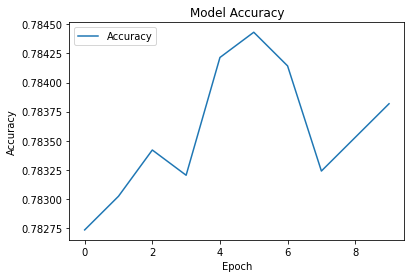

In [7]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy'], loc='upper left')
plt.show()

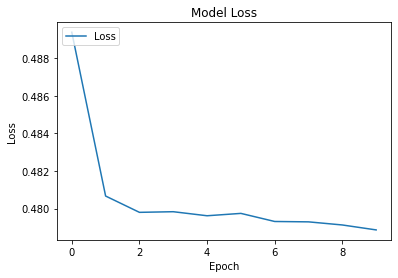

In [8]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()